In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

%matplotlib inline

def analyseSimulation(eDepFileTitle, rootFileTitle, particle, energy):

    #################################
    ## root file and data frame
    #################################

    tree = uproot.open(f"{rootFileTitle}_{particle}_{energy}GeV.root")["Eecs"]
    df = tree.arrays(library="np")

    number_of_events = np.max(df['evntID'])+1

    escapedEnergy = np.sum(df['escE'])/number_of_events

    treeEdep = uproot.open(f"{rootFileTitle}_{particle}_{energy}GeV.root")["Edep"]
    eEscInEvent = treeEdep.arrays(["eDep"], library="np")
    eEscInEvent = energy*1000-eEscInEvent["eDep"]

    # eEscInEvent = np.array([np.sum(df["escE"][df["evntID"] == evID]) for evID in range(number_of_events)])

    

    #################################
    ## eDep File & eDep mesh
    #################################

    nDivisionsXY = 175
    nDivisionsR = 88
    sLength = 87.5

    fileEdep = open(f"{eDepFileTitle}_{particle}_{energy}GeV_Box.txt")

    mesh = np.zeros((nDivisionsXY, nDivisionsXY))

    fileEdep.readline() # skip 3 firts lines
    fileEdep.readline()
    fileEdep.readline()

    for line in fileEdep:
        lineSplit = line.split(",")

        ix = int(lineSplit[0])
        iy = int(lineSplit[1])

        eDep = float(lineSplit[3])

        mesh[ix, iy] += eDep

    mesh/=number_of_events

    #################################
    ## eDep File & eDep r dependent hist
    #################################

    fileRdepend = open(f"{eDepFileTitle}_{particle}_{energy}GeV_Cylinder.txt")

    rhist = np.zeros((nDivisionsR,))

    fileRdepend.readline() # skip 3 firts lines
    fileRdepend.readline()
    fileRdepend.readline()

    for line in fileRdepend:
        lineSplit = line.split(",")

        ir = int(lineSplit[2])

        eDep = float(lineSplit[3])

        rhist[ir] += eDep

    rhist/=number_of_events

    #################################
    ## eDep plots
    #################################
    plt.figure(figsize=(12.8, 4.8))
    grid = plt.GridSpec(2, 2, wspace=0.3, hspace=0.1)


    ## eDep mesh
    plt.subplot(grid[:, 0])
    plt.imshow(np.transpose(mesh), extent=(-sLength, sLength, -sLength, sLength), norm=colors.LogNorm(vmin=1e-3))
    cbar = plt.colorbar()
    cbar.ax.set_ylabel("Deposited Energy [MeV]")
    plt.xlabel("x [mm]")
    plt.ylabel("y [mm]")
    plt.title(f"Energy deposition of {energy} GeV {particle}")
    ax = plt.gca()
    ax.text(0.05, 0.05, "dx = dy = 1 mm", transform=ax.transAxes, color="white")  
    
    ## eDep r dependent plots mesh
    rCount = (np.arange(nDivisionsR) + 0.5)
    plt.subplot(grid[0, 1])
    plt.plot(rCount, np.cumsum(rhist), "-")
    plt.xlabel("r [mm]")
    plt.ylabel("Integrated $E_{dep}$ [MeV]")
    plt.yscale("log")  
    ax = plt.gca()
    ax.text(0.1, 0.1, "Mean (over events) deposited energy {:.2f} MeV".format(np.sum(mesh)), transform=ax.transAxes)  
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top') 


    plt.subplot(grid[1, 1])
    plt.plot(rCount/27.0, rhist, "-")
    plt.xlabel("r [$R_{M}$]")
    plt.ylabel("$\\frac{dE_{dep}}{dr}$ [MeV/mm]")
    plt.yscale("log")

    plt.savefig(f"plots/Deposited_energy_of_{energy}_GeV_{particle}.png")


    #################################
    ## E escape plots
    #################################

    plt.figure(figsize=(12.8*1.1, 4.8*1.1))
    grid = plt.GridSpec(2, 2, wspace=0.2, hspace=0.5) 


    sideEscapeSelect = np.fabs(df['Zpos']) < 199.9

    ## Z of side escape
    plt.subplot(grid[0, 0])
    plt.hist(df["Zpos"][sideEscapeSelect] + 200, weights=df["escE"][sideEscapeSelect]/number_of_events, bins=100)
    plt.title(f"Histogram of side-escaping energy, {particle} {energy} GeV")
    plt.xlabel("Depth in volume [mm]")
    plt.ylabel("$E_{dep}$ [MeV]")
    ax = plt.gca()
    ax.text(0.05, 0.9, "The bin size is 4 mm.", transform=ax.transAxes) 
    ax.text(0.05, 0.6, "Mean (over events)\nside-escaped energy\nis {:.2f} MeV".format(np.sum(df["escE"][sideEscapeSelect])/number_of_events), 
            transform=ax.transAxes) 

    ## event wise escaping distribution
    plt.subplot(grid[1, 0])
    plt.hist(eEscInEvent[eEscInEvent < (np.mean(eEscInEvent) + 5*np.std(eEscInEvent))], bins= int( np.sqrt(number_of_events) ))
    plt.title("Event-wise histogram of escaped energy")
    plt.xlabel("Escaped energy [MeV]")
    ax = plt.gca()
    ax.text(0.7, 0.8, "$\mu$ = {:.2f} MeV\nRMS = {:.2f} MeV".format(np.mean(eEscInEvent), np.std(eEscInEvent)), 
            transform=ax.transAxes) 

    ## XY of side escape
    plt.subplot(grid[:, 1])
    plt.hist2d(df["Xpos"][sideEscapeSelect], df["Ypos"][sideEscapeSelect], 
               weights=df["escE"][sideEscapeSelect]/number_of_events, bins=15, norm=colors.LogNorm(vmin=0.05))
    cbar = plt.colorbar()
    cbar.ax.set_ylabel("Side-escaped energy [MeV]")
    plt.xlabel("x [mm]")
    plt.ylabel("y [mm]")
    plt.title("Histogram of side-escaping energy")
    ax = plt.gca()
    ax.text(0.3, 0.1, "dx = dy = {:.2f} mm".format(sLength*2/15), transform=ax.transAxes)  

    plt.savefig(f"plots/Side_energy_escaping_of_{energy}_GeV_{particle}.png")

    #################################
    ## Top bottom escape plots
    #################################
    fig = plt.figure(figsize=(12.8, 4.8))
    plt.subplots_adjust(wspace=0.31)

    ## top escape hist
    plt.subplot(1,2,1)
    topEscapeSelect = df['Zpos'] < -199.99
    plt.hist2d(df["Xpos"][topEscapeSelect], df["Ypos"][topEscapeSelect], 
               weights=df["escE"][topEscapeSelect]/number_of_events, bins=15, norm=colors.LogNorm(vmin=0.05))
    cbar = plt.colorbar()
    cbar.ax.set_ylabel("Entrance-escaped energy [MeV]")
    plt.xlabel("x [mm]")
    plt.ylabel("y [mm]")
    plt.title(f"Entrance-escaping energy, {particle} {energy} GeV")
    ax = plt.gca()
    ax.text(0.55, 0.01, "dx = dy = {:.2f} mm".format(sLength*2/15), transform=ax.transAxes, color="white")
    ax.text(0.05, 0.01, 
            "Mean (over events)\ntop-escaped energy\nis {:.2f} MeV".format(np.sum(df["escE"][topEscapeSelect])/number_of_events),
            transform=ax.transAxes, color="white")

    ## top escape hist
    plt.subplot(1,2,2)
    botEscapeSelect = df['Zpos'] > 199.99
    plt.hist2d(df["Xpos"][botEscapeSelect], df["Ypos"][botEscapeSelect], 
               weights=df["escE"][botEscapeSelect]/number_of_events, bins=15, norm=colors.LogNorm(vmin=0.05))
    cbar = plt.colorbar()
    cbar.ax.set_ylabel("Exis-escaped energy [MeV]")
    plt.xlabel("x [mm]")
    plt.ylabel("y [mm]")
    plt.title("Exis-escaping energy")
    ax = plt.gca()
    ax.text(0.55, 0.01, "dx = dy = {:.2f} mm".format(sLength*2/15), transform=ax.transAxes, color="white")
    ax.text(0.05, 0.01, 
            "Mean (over events)\nbottom-escaped energy\nis {:.2f} MeV".format(np.sum(df["escE"][botEscapeSelect])/number_of_events),
            transform=ax.transAxes, color="white")
    
    plt.savefig(f"plots/Tob_bottom_energy_escaping_of_{energy}_GeV_{particle}.png")



In [2]:
# analyseSimulation("build/eDep","build/eEsc", "electron", 1)

In [3]:
# analyseSimulation("build/eDep","build/eEsc", "electron", 25)

In [4]:
# analyseSimulation("build/eDep","build/eEsc", "gamma", 1)

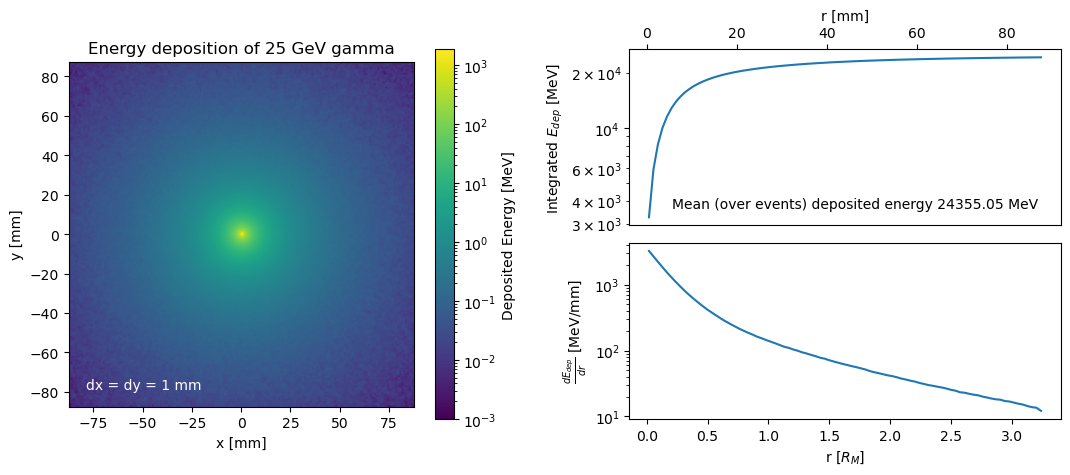

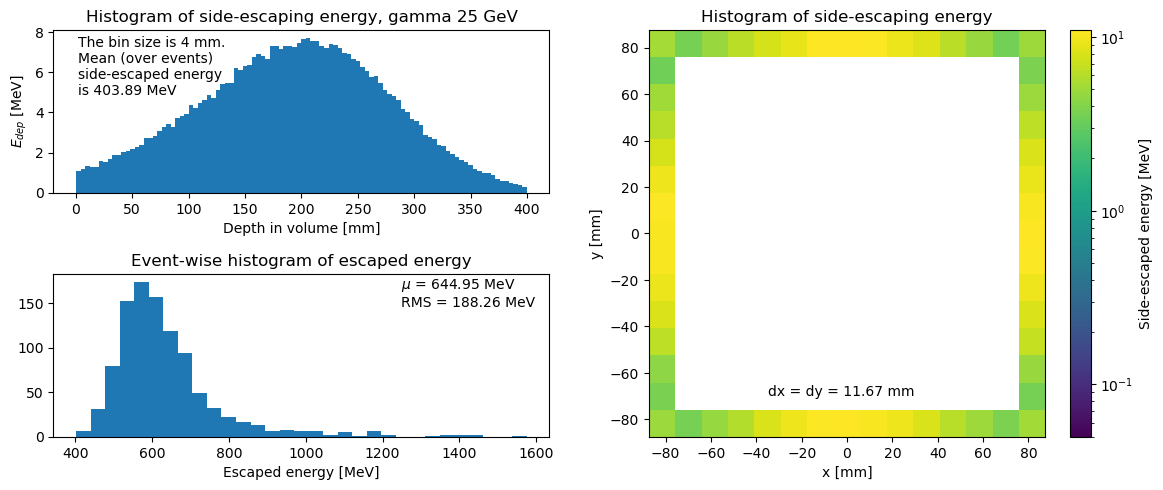

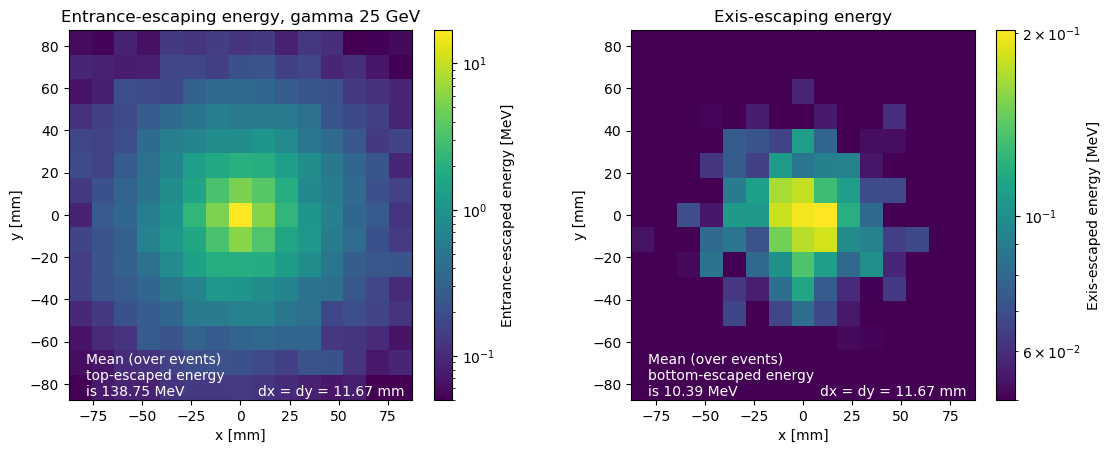

In [5]:
analyseSimulation("build/eDep","build/eEsc", "gamma", 25)